In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az
import stan

import nest_asyncio
nest_asyncio.apply()

# Bayesian Linear Regression

In this notebook, we implement a simple Bayesian Linear Regression model in `Stan`. This model samples from the posterior $p(\alpha, \beta | \mathcal{D})$ given dataset $\mathcal{D} = \{x_n, y_n\}_{n=1}^N$.

## Part 1: Simulating Data

We simulate the dataset $\mathcal{D}$ using a set of predetermined values for intercept parameter $\alpha$, slope parameter $\beta$, and variance (noise) parameter $\sigma$. This set of parameters generates the dataset via the following relations:

$$
\begin{equation}
    y_n = \alpha + \beta x_n + \epsilon_n, \quad \epsilon_n \sim \mathcal{N}(0, \sigma^2)
\end{equation}
$$

In [4]:
### Simulating the dataset

def simulator(alpha=2.3, beta=4., sigma=2., n_obs=100, rng=None):

    if rng is None:
        rng = np.random.default_rng(2024)


    # Simulator
    x = rng.normal(size=n_obs)
    y = alpha + beta * x + sigma * rng.normal(size=n_obs)

    return x, y

In [5]:
N_OBS = 100
x, y = simulator(n_obs=N_OBS)

In [ ]:
# Visualizing data

## TODO

## Part 2: Generative Model

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    \nonumber \alpha &\sim \mathcal{N}(0, 10)\\
    \nonumber \beta &\sim \mathcal{N}(0, 10)\\
\nonumber y_n &\sim \mathcal{N}(\alpha + \beta\,x_n, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [11]:
#### Your code here

blr_program = """ 
data {
    int<lower=1> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma2;
}

transformed parameters {
    real sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ normal(0, 10);
    sigma2 ~ inv_gamma(1, 1);

    // Likelihood
    y ~ normal(alpha + beta * x, sigma2);
}
"""

In [10]:
### Create Stan-friendly data dictionary
blr_data = {
    'N': N_OBS,
    'x': x,
    'y': y
}

blr_data

{'N': 100,
 'x': array([ 1.02885687,  1.64192004,  1.14671953, -0.97317952, -1.3928001 ,
         0.06719636,  0.86135092,  0.5091868 ,  1.81028557,  0.75084347,
         0.63975955, -0.73132252, -1.10771704,  1.48440559,  0.0489124 ,
         0.81152012, -1.37642284, -0.43637074, -1.29109163, -0.77567868,
         0.90306308, -1.48058133, -0.53409283,  0.16378857, -0.6684703 ,
        -0.25228976, -0.22186154,  0.41813857, -0.43125455,  0.27226068,
         0.0568192 ,  0.42456926,  0.22494339,  1.65768406, -0.66367607,
         1.19918717, -0.40261243, -0.95792617,  1.21119447, -0.4395059 ,
        -0.38763587, -1.38868368, -2.09819679,  0.63430094, -1.16526638,
         0.77827299,  1.8481673 , -0.11479795, -1.1266151 ,  0.39419917,
         0.76172847, -0.26179038,  0.01746449,  1.33527073,  1.26545198,
         0.70997823, -0.86640088, -0.05367557,  0.60291732, -0.21186587,
        -0.61001793, -0.76538872, -0.63200882, -0.67160479, -0.45111139,
         1.14567723, -0.80064198,  

In [12]:
blr_posterior = stan.build(blr_program, data=blr_data)

Building...



Building: found in cache, done.

## Part 3: Posterior Sampling

In [13]:
%%time
fit_br = br_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.00011 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.26 seconds.
  Adjust your expectations accordingly!


CPU times: user 224 ms, sys: 216 ms, total: 440 ms
Wall time: 701 ms


Convergence and efficiency diagnostics

/home/geraldwong/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


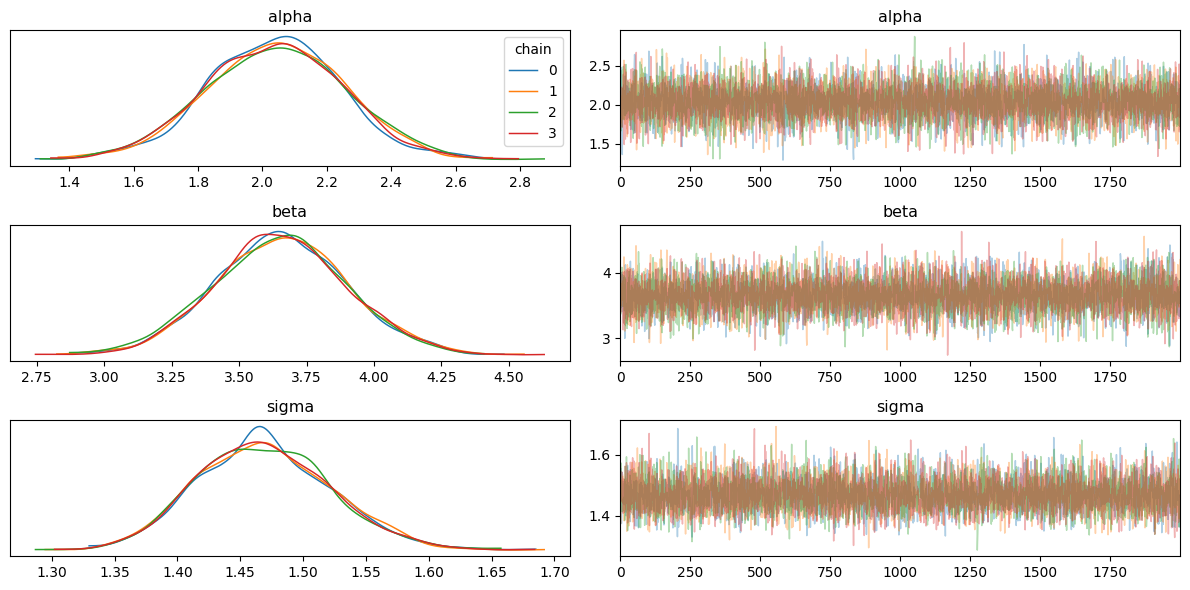

In [14]:
# Convergence and efficiency diagnostics
az.plot_trace(fit_br, var_names=['alpha', 'beta', 'sigma'], compact=False, legend=True)
plt.tight_layout()

In [15]:
summary = az.summary(fit_br)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.039,0.217,1.640,2.462,0.002,0.002,8308.0,6199.0,1.0
beta,3.656,0.246,3.187,4.114,0.003,0.002,8768.0,6403.0,1.0
sigma2,2.161,0.156,1.876,2.457,0.002,0.001,7958.0,6264.0,1.0
sigma,1.469,0.053,1.370,1.567,0.001,0.000,7958.0,6264.0,1.0


Inferential performance

In [23]:
# First
alpha, beta, sigma

(2.3, 4.0, 2.0)

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

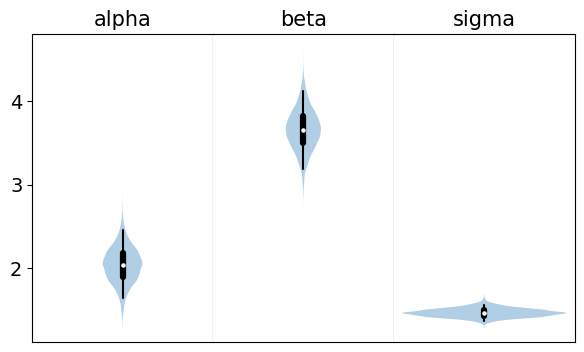

In [16]:
az.plot_violin(fit_br, var_names=['alpha', 'beta', 'sigma'], figsize=(7, 4))

## Part 4: Rerun

In [19]:
resim_x, resim_y = simulator(n_obs=1000)

In [20]:
resim_data = {
    'N': 1000,
    'x': resim_x,
    'y': resim_y
}

In [21]:
resim_posterior = stan.build(blr_program, data=resim_data)

Building...



Building: found in cache, done.

In [22]:
resim_fit = resim_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000121 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000134 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.34 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_7k__58af/model_s2jgiodj.stan', line 26, column 4 to column 41)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either 

/home/geraldwong/.local/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


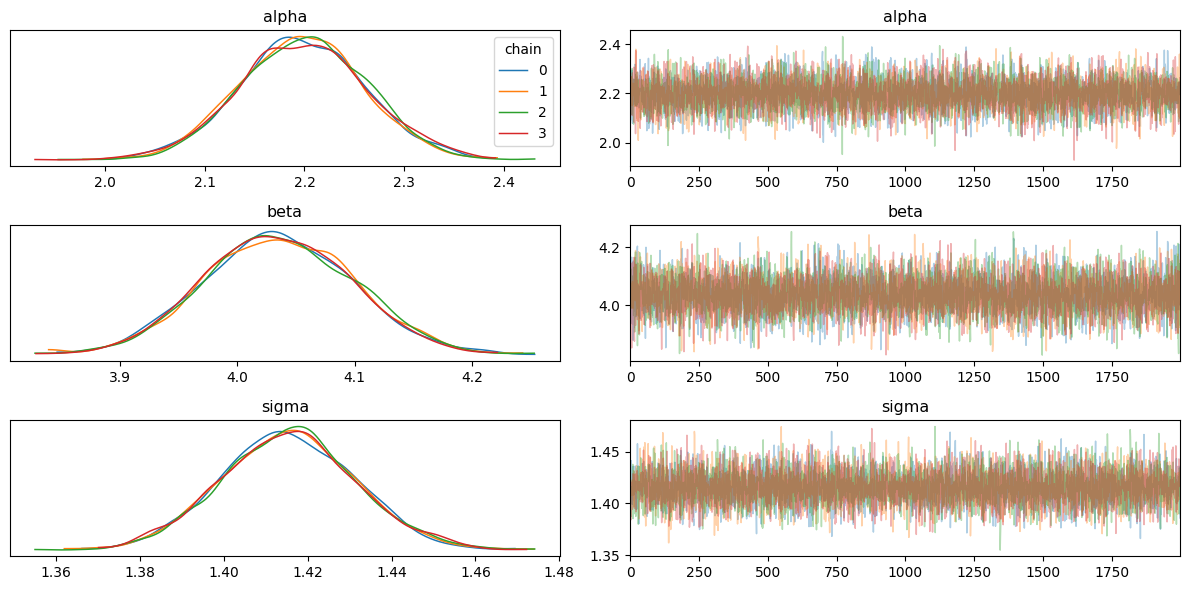

In [23]:
# Convergence and efficiency diagnostics
az.plot_trace(resim_fit, var_names=['alpha', 'beta', 'sigma'], compact=False, legend=True)
plt.tight_layout()

In [24]:
summary = az.summary(resim_fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.198,0.063,2.075,2.312,0.001,0.000,8400.0,5092.0,1.0
beta,4.035,0.063,3.917,4.153,0.001,0.001,7562.0,5749.0,1.0
sigma2,2.004,0.045,1.916,2.087,0.000,0.000,8705.0,6093.0,1.0
sigma,1.415,0.016,1.384,1.445,0.000,0.000,8705.0,6093.0,1.0
